In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class LinearLayer:
    # A linear layer of shape (d_in × d_out) with (tp_in × tp_out)-degree tensor
    # parallelism, dp-degree data parallelism, and bytewidth precision.
    def __init__(self, d_in, d_out, tp_in, tp_out, dp, bytewidth):
        self.d_in = d_in
        self.d_out = d_out
        self.tp_in = tp_in
        self.tp_out = tp_out
        self.dp = dp
        self.bytewidth = bytewidth

        # Derived dimensions.
        self.N = d_in*d_out                             # number of parameters
        self.d_in_local = d_in/tp_in                    # local input dimension
        self.d_out_local = d_out/tp_out                 # local output dimension
        self.N_local = self.d_in_local*self.d_out_local # local number of parameters

class ChinchillaOptimalModel:
    def __init__(self, training_flop, hidden_factor=5, bytewidth=2):
        self.training_flop = training_flop
        self.bytewidth = bytewidth
        self.hidden_factor = hidden_factor
        self.N = np.sqrt(training_flop/120)               # number of parameters
        self.D = 20*self.N                                # number of training tokens
        self.B = 4e6 * (training_flop/1e25)**(1/6)        # batch size
        self.L = 120 * (training_flop/1e25)**(1/6)        # number of residual blocks
        self.d = np.sqrt(self.N/(2*hidden_factor*self.L)) # residual dimension

class Parallelism:
    def __init__(self, pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch):
        self.pp = pp
        self.dp = dp
        self.tp_residual = tp_residual
        self.tp_hidden = tp_hidden
        self.n_microbatches_per_batch = n_microbatches_per_batch

        self.n_devices = pp*dp*tp_residual*tp_hidden
    
    def __getitem__(self, key):
        return Parallelism(self.pp[key], self.dp[key], self.tp_residual[key], self.tp_hidden[key], self.n_microbatches_per_batch[key])

class Device:
    def __init__(self, name, flop_per_sec_8bit, global_Bps, net_Bps,
                 base_util=0.8, network_reduction=True):
        self.name = name
        self.flop_per_sec_8bit = flop_per_sec_8bit
        self.global_Bps = global_Bps
        self.net_Bps = net_Bps
        self.base_util = base_util
        self.network_reduction = network_reduction

    def __repr__(self):
        return self.name
    
    def all_reduce_communication(self, n, p):
        # The number of words this device has to send or receive to participate
        # in an all-reduce of a vector of local size n, with p - 1 other
        # devices.
        if self.network_reduction:
            # If p > 1, in this case a device on the network fabric does the
            # actual reduction and broadcast and we only need to transmit and
            # receive n words.
            return (p > 1)*(2*n)
        else:
            # In this case we assume a bandwidth-optimal reduce-scatter +
            # multicast communication pattern, where each device is responsible
            # for reducing n/p words:
            #
            #  Step 1. Transmit p - 1 parts of size n/p to the devices
            #          responsible for reducing those parts.
            #
            #  Step 2. Receive p - 1 copies of the part of size n/p that I'm
            #          responsible for reducing from my peers.
            #
            #  Step 3. Reduce the p copies of my part and multicast the result
            #          to my peers (optimistically assumed to be free for
            #          simplicity).
            #
            #  Step 4. Receive p - 1 parts of size n/p that my peers were
            #          responsible for reducing.
            return 3*(p - 1)*n/p

    def linear_layer_fwd_bwd_secs(self, lin_layer, b):
        # Determine the time to compute a forward and backward pass through
        # lin_layer on a microbatch of b tokens. We take into account the time
        # of tensor FLOP, global memory IO, and tensor-parallel all-reduce
        # communication.
        #
        # Some assumptions (all "optimistic"):
        #  - Data movement and computation are fully overlappable, via the
        #    mechanism of multiple microbatches simultaneously in flight.
        #
        #  - Pipeline-parallel communication time is negligible (though deep
        #    pipelines may cause a bubble, which is modeled elsewhere).
        #
        #  - Pointwise operations such as activation functions and
        #    normalizations are negligible. So is attention and any
        #    communication it requires.
        #
        #  - b/dp is substantially smaller than d_in/tp_in and d_out/tp_out,
        #    where dp is the data parallel degree, tp_in is the input tensor
        #    parallel degree, and tp_out is the output tensor parallel degree.
        #    This is because this tends to be communication-optimal due to the
        #    significant communication costs of tensor parallelism compared to
        #    data parallelism. This in turn has a few implications:
        #
        #     1. The input and output matrix tends to be quite rectangular,
        #        which puts the on-chip data movement bottleneck at global
        #        memory rather than shared memory banks, L2 cache, or the
        #        SM-to-SM DSMEM network. This is because the SM- and warp-level
        #        tiles can still be large and approximately square-shaped, which
        #        removes these levels of the memory hierarchy as a bottleneck,
        #        however there isn't freedom to do this at the global level.
        #        Thus we do not model data movement on-chip except to/from
        #        global memory.
        #
        #     2. We treat global memory IO of activations as negligible. (We
        #        also assume activations fit in global memory and don't need to
        #        be recomputed during the backward pass.) However, we assume
        #        weights and their gradients cannot fit in L2 cache, such that
        #        global memory IO is required each time they're accessed.
        #
        #  - The all-reduce communication pattern is a bandwidth-optimal
        #    reduce-scatter followed by a multicast, and we treat the multicast
        #    transmission as free for simplicity.
        #
        # We also don't worry about whether our parallelism degrees divide the
        # tensor dimensions.
        d_in_local, d_out_local = lin_layer.d_in_local, lin_layer.d_out_local
        N_local = lin_layer.N_local
        tp_in, tp_out, dp = lin_layer.tp_in, lin_layer.tp_out, lin_layer.dp
        bytewidth = lin_layer.bytewidth
        b_local = b/dp

        flop, global_io, net_io = 0, 0, 0

        # Forward pass.
        global_io += N_local                                                   # Read weights.
        flop      += 2*N_local*b_local                                         # Compute output activations: Y = WX.
        net_io    += self.all_reduce_communication(d_out_local*b_local, tp_in) # All-reduce activations.

        # Backward pass (weight gradients).
        flop      += 2*N_local*b_local                                         # Compute weight gradients: dL/dW = (dL/dY)X^T.
        global_io += 2*N_local                                                 # Accumulate weight gradients (read + write).
        # Note: On the gradient accumulation step for the first microbatch,
        # we're overcounting global IO because technically there's no read
        # required. This is made up for by our ignoring of activation global IO
        # (e.g. during all-reduce or reloading in the backward pass), which
        # *across the whole batch* is greater than a single weight gradient
        # read.
    
        # Backward pass (activation gradients).
        global_io += N_local                                                   # Read weights.
        flop      += 2*N_local*b_local                                         # Compute input gradients: dL/dX = W^T(dL/dY).
        net_io    += self.all_reduce_communication(d_in_local*b_local, tp_out) # All-reduce input gradients.

        # Total time for each type of operation. (base_util due to thermal
        # throttling is presumed to affect FLOP/s and global memory B/s, but not
        # net B/s).
        flop_secs = (flop*bytewidth)/(self.base_util*self.flop_per_sec_8bit)
        global_io_secs = (global_io*bytewidth)/(self.base_util*self.global_Bps)
        net_io_secs = (net_io*bytewidth)/self.net_Bps
        return np.array([flop_secs, global_io_secs, net_io_secs])

    def linear_layer_end_of_batch_secs(self, lin_layer):
        # Determine the time for the end-of-batch gradient all-reduce (we assume
        # the optimizer step itself is negligible).
        io = self.all_reduce_communication(lin_layer.N_local, lin_layer.dp)
        global_io_secs = (io*lin_layer.bytewidth)/(self.base_util*self.global_Bps)
        net_io_secs = (io*lin_layer.bytewidth)/self.net_Bps
        return np.maximum(global_io_secs, net_io_secs)

    def model_batch_secs(self, model, parallelism):
        # Determine the time to train on a single batch of the given model,
        # given the provided parallelism degrees.
        pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch =\
            parallelism.pp, parallelism.dp, parallelism.tp_residual, parallelism.tp_hidden, parallelism.n_microbatches_per_batch

        # Construct the two linear layers for each residual block.
        lin1 = LinearLayer(model.d, model.hidden_factor*model.d, tp_residual, tp_hidden, dp, model.bytewidth)
        lin2 = LinearLayer(model.hidden_factor*model.d, model.d, tp_hidden, tp_residual, dp, model.bytewidth)

        # Determine the number of pipeline steps, in the bubble and at steady
        # state. Since we optimistically treat pipeline-parallel communication
        # as free, we assume maximal interleaving to minimize bubble fraction.
        assert np.all(pp <= model.L), f'pp={pp}, L={model.L}'
        assert np.all(pp <= n_microbatches_per_batch), f'pp={pp}, n_microbatches_per_batch={n_microbatches_per_batch}'
        residual_blocks_per_stage = model.L/pp
        pipeline_bubble_steps = pp - 1
        pipeline_full_steps = residual_blocks_per_stage*n_microbatches_per_batch
        total_steps = pipeline_bubble_steps + pipeline_full_steps

        # Determine the microbatch size.
        b = model.B / n_microbatches_per_batch
        step_secs = (self.linear_layer_fwd_bwd_secs(lin1, b) + self.linear_layer_fwd_bwd_secs(lin2, b)).max(axis=0)
        pipeline_bubble_secs = pipeline_bubble_steps*step_secs
        pipeline_full_secs = pipeline_full_steps*step_secs

        # TODO: Allow overlapping with the very last microbatch backward pass
        #       and very first microbatch forward pass.
        block_end_of_batch_secs = self.linear_layer_end_of_batch_secs(lin1) + self.linear_layer_end_of_batch_secs(lin2)
        gradient_secs = residual_blocks_per_stage*block_end_of_batch_secs

        return pipeline_bubble_secs + pipeline_full_secs + gradient_secs,\
            (pipeline_bubble_secs, pipeline_full_secs, gradient_secs)

    def model_train_secs(self, model, parallelism):
        num_batches = model.D/model.B
        batch_secs, _ = self.model_batch_secs(model, parallelism)
        return num_batches*batch_secs

In [6]:
def add_next_parallelism(device, model, par):
    par_last = par[-1]

    # Consider doubling each of the four parallelism degrees, along with all
    # power of 2 microbatch counts between 1 and 2^22.
    pp = np.full(4, par_last.pp)
    pp[0] *= 2
    dp = np.full(4, par_last.dp)
    dp[1] *= 2
    tp_residual = np.full(4, par_last.tp_residual)
    tp_residual[2] *= 2
    tp_hidden = np.full(4, par_last.tp_hidden)
    tp_hidden[3] *= 2

    idx_par, idx_mb = np.meshgrid(np.arange(4), np.arange(23))
    pp = pp[idx_par].flatten()
    dp = dp[idx_par].flatten()
    tp_residual = tp_residual[idx_par].flatten()
    tp_hidden = tp_hidden[idx_par].flatten()
    n_microbatches_per_batch = 2**idx_mb.flatten()

    # Filter out invalid parallelism degrees.
    valid = (pp <= model.L) & (pp <= n_microbatches_per_batch)
    par2 = Parallelism(pp[valid], dp[valid], tp_residual[valid], tp_hidden[valid], n_microbatches_per_batch[valid])

    # Find the best by total training time.
    train_secs = device.model_train_secs(model, par2)
    best_idx = np.argmin(train_secs)
    # Add the best parallelism degree.
    return Parallelism(np.append(par.pp, par2.pp[best_idx]),
                       np.append(par.dp, par2.dp[best_idx]),
                       np.append(par.tp_residual, par2.tp_residual[best_idx]),
                       np.append(par.tp_hidden, par2.tp_hidden[best_idx]),
                       np.append(par.n_microbatches_per_batch, par2.n_microbatches_per_batch[best_idx]))

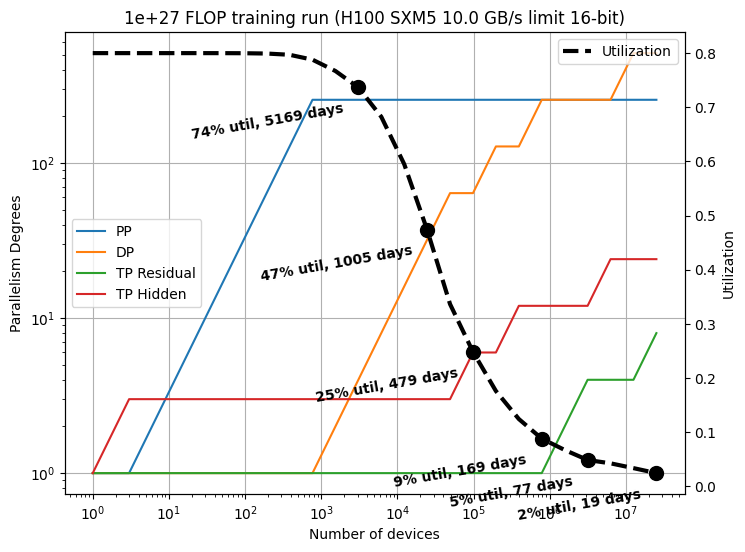

In [30]:
a100 = Device('A100', 623.7e12, 1555e9, 600e9)
h100 = Device('H100 SXM5', 1979e12, 3352e9, 900e9)
band_limit = 10e9
h100_rest = Device(f'H100 SXM5 {band_limit/1e9:.1f} GB/s limit', 1979e12, 3352e9, band_limit)
device = h100_rest
#device = Device('64 x H100 SXM5', 64*1979e12, np.inf*3352e9, 30e9)
model = ChinchillaOptimalModel(1e27)

tp_residual = np.concatenate(([1]*4, np.arange(1, 25)))
tp_hidden = np.concatenate((np.arange(1, 5), np.arange(1, 25)*model.hidden_factor))
pp = np.ones_like(tp_hidden)
dp = np.ones_like(tp_hidden)
n_microbatches_per_batch = np.ones_like(tp_hidden)
par = Parallelism(pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch)

theoretical_flop_per_sec = par.n_devices*device.flop_per_sec_8bit/model.bytewidth
actual_flop_per_sec = model.training_flop/device.model_train_secs(model, par)
util = actual_flop_per_sec/theoretical_flop_per_sec
full_util = util >= 0.9999*device.base_util
par = par[full_util]
for i in np.arange(np.log2(15e6/par.n_devices[-1])):
    par = add_next_parallelism(device, model, par)

theoretical_flop_per_sec = par.n_devices*device.flop_per_sec_8bit/model.bytewidth
training_secs = device.model_train_secs(model, par)
actual_flop_per_sec = model.training_flop/training_secs
util = actual_flop_per_sec/theoretical_flop_per_sec

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title(f'{model.training_flop} FLOP training run ({device.name} {model.bytewidth*8}-bit)')
ax.set_xlabel('Number of devices')
ax.set_ylabel('Parallelism Degrees')
ax.plot(par.n_devices, par.pp, label='PP')
ax.plot(par.n_devices, par.dp, label='DP')
ax.plot(par.n_devices, par.tp_residual, label='TP Residual')
ax.plot(par.n_devices, par.tp_hidden, label='TP Hidden')
# ax.plot(par.n_devices, par.n_microbatches_per_batch, label='Microbatches')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

ax2 = ax.twinx()
ax2.set_ylabel('Utilization')
ax2.plot(par.n_devices, util, label='Utilization', color='black', linestyle='--', linewidth=3)
idxs = []
training_days = training_secs/86400
for u in [0.75, 0.5, 0.25, 0.1, 0.05, 0.02]:
    i = np.argmin(np.abs(util - u))
    idxs.append(i)
    ax2.annotate(f'{int(np.round(100*util[i]))}% util, {int(np.round(training_days[i]))} days', (par.n_devices[i], util[i]), xytext=(-10, -10),
                 textcoords='offset points', ha='right', va='top', rotation=10, fontsize=10, weight='bold')
    if np.all(util > u):
        break
ax2.plot(par.n_devices[idxs], util[idxs], 'o', color='black', markersize=10)
ax.legend(loc='center left')
ax2.legend()

ax.grid()

In [690]:
util[training_days[par.n_devices <= 15e6].argmin()]

0.002247441363464536

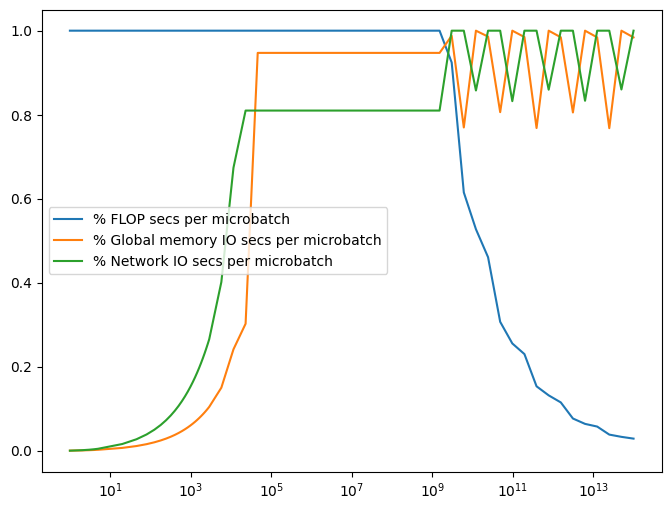

In [650]:
secs, (flop_secs, global_io_secs, net_io_secs) =\
                                 device.linear_layer_fwd_bwd_secs(LinearLayer(model.d, model.hidden_factor*model.d, par.tp_residual, par.tp_hidden, par.dp, model.bytewidth),
                                 model.B/par.n_microbatches_per_batch)

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(par.n_devices, flop_secs/secs, label='% FLOP secs per microbatch')
plt.plot(par.n_devices, global_io_secs/secs, label='% Global memory IO secs per microbatch')
plt.plot(par.n_devices, net_io_secs/secs, label='% Network IO secs per microbatch')
plt.legend()
plt.xscale('log')
# plt.yscale('log')